In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# A Discrete Convolution Program (5 pts)

Write a discrete convolution function `myConv` that convolves two arrays {$f_i, i = 0, \dots , N_f-1$}
and {$w_j, j = 0, \dots , N_w-1$} to obtain an output time series {$g_n$}. For simplicity, assume a fixed sampling interval $\Delta = 1$, and further, that $f$ and $w$ are $0$ outside of their sampled regions. 

 1. How long is {$g_n$}? In other words, how many non-zero points can it have? Justify your answer. 
 2. Please copy and paste your function `g = myConv(f, w)` to the PDF report.
 3. Provide a test to convince yourself (and me) that your function agrees with `numpy.convolve`. For example, generate two random timeseries $f$, $w$ with $N_f=50$, $N_w=100$, drawing each element from $U[0,1]$, and plot the difference between your function's output and numpy's. Include the code for your test in the PDF report.
 4. Compare the speed of your `myConv` function to the NumPy function. Provide a plot of the comparison, and include your python code in the PDF report. Is your function faster or slower than the NumPy function? Can you suggest why that is the case?

_Hint_: For the speed test part, make up your own $f_i$ and $w_j$ time series, and for simplicity, study the cases
of $N_f = N_w = 10, 100, 1000, 10000$. To accurately time each computation of the convolution function, import the
time module and place calls to `time.time` around your code:
```
import time
t1 = time.time()
g = myConv(f, w)
t2 = time.time()
print(t2-t1)
```
Alternatively, use the `timeit` module:
```
import timeit
print(timeit.timeit('g = myConv(f, w)', number=10000))
```

# 1. 

The number of non-zero points $g_n$ can have is $N_f$ + $N_w$ - 1. This is because we are essentially "sliding" one array (after flipping it) over the other one to do a convolution (the convolution will have a value of zero everywhere else). The first time these arrays will overlap is when the last element of the flipped array (the one we "slide") overlaps with the first element of the other array. The last time they overlap is when the first element of the flipped array overlaps with the last element of the other array.

Lets call F the flipped array we slide over W.

From the first time the arrays overlap until the last element of F no longer overlaps with any element in W, we perform $N_w$ "slides". Then all that is left is the number of slides until the first element in F overlaps with the last element of W. This number of slides is $N_f$-1 (since the last element of F is already "past" W). Thus the total number of non-zero values in the convolution $g_n$ is $N_w$ + $N_f$ - 1.

    Note that a "proof" of this can be found in the course lecture slides

# 2.

Note: I did this question on my own prior to the lecture on discrete convolution, so I implemented the convolution type 'same' (ie the result is of the same length as the longer of the two arrays).

After the lecture I realized that the convolution we are asked for is 'full' convolution (of length given in part 1 above) so I implemented that as well. The 'full' convolution is the function called myConv, and the 'same' convolution is called myConv1.

In [2]:
def myConv1(W, F, delta=1):
    '''
    Returns W∗F, the convolution of array W with array F such that the result is the same size as F
    ie. 'same' convolution
    
    Assumes F is the larger array. If W is larger, swap the arrays
    
    Uses sampling interval given by delta.
    '''

    # make sure W is the smaller array
    if len(W) > len(F):
        W, F = F, W
    
    # If smaller array is even in length, 'prepend' a zero to it (seems to be what np.convolve does)
    if len(W)%2==0:
        W = np.insert(W, 0, 0)
    
    
    # Zero-pad F based on the size of W
    k = np.shape(W)[0]
    padWidth = int((k-1)/2)
    
    F = np.pad(F, (padWidth, padWidth), 'constant')
    
    # initialize matrix for the result of convolution
    result = np.zeros(np.shape(F))
    
    # Flip the array so that you can just apply correlation (convolution is correlation but with the "filter" flipped in all dimensions)
    W = W[::-1]

    # Perform correlation    
    for i in range(padWidth, F.shape[0]-padWidth):        
        
        subArray = F[i-padWidth:i+padWidth+1]
        result[i] = np.dot(W, subArray)
            
    
    # scale the result by the sampling rate:
    result = delta*result
    
    # Remove the padding?
    result = result[padWidth:result.shape[0]-padWidth]
    
    return result

In [7]:

def myConv(W, F, delta=1):
    '''
    Returns W∗F, the convolution of array W with array F such that the result is of length len(F) + len(W) - 1
    ie. 'full' convolution
    
    Uses sampling interval given by delta.
    '''
    
    evenW = len(W)%2==0
    # If smaller array is even in length, 'prepend' a zero to it (seems to be what np.convolve does)
    if evenW:
        W = np.insert(W, 0, 0)


    # initialize matrix for the result of convolution
    result = np.zeros(len(F) + len(W) - 1)
    
    
    # Zero-pad F based on the size of W
    k = np.shape(W)[0]
    padWidth = int((k-1))
    
    F = np.pad(F, (padWidth, padWidth), 'constant')
    

    # Flip the array so that you can just apply correlation (convolution is correlation but with the "filter" flipped in all dimensions)
    W = W[::-1]


    # Perform correlation    
    for i in range(padWidth//2, len(F)-len(W)//2):        

        subArray = F[i-padWidth//2:i+padWidth//2+1]
        result[i-len(W)//2] = np.dot(W, subArray)
            
    
    # scale the result by the sampling rate:
    result = delta*result
    
    # removing the extra zero that results from prepending a zero to W
    if evenW:
        result = result[1:]
    
    return result

In [8]:
# Quick test to check that both my convolution functions work
a = np.array([1, 0, 0, 0])
b = np.array([1, 2, 3, 4, 5, 6])

print(np.convolve(a, b, 'same'))
print(myConv1(a, b, 1))


print(np.convolve(a, b))
print(myConv(a, b, 1))

[2 3 4 5 6 0]
[2. 3. 4. 5. 6. 0.]
[1 2 3 4 5 6 0 0 0]
[1. 2. 3. 4. 5. 6. 0. 0. 0.]


# 3.

Notice that the difference between numpy.convolve and myConv is very small: 
5.1598503419391096e-15


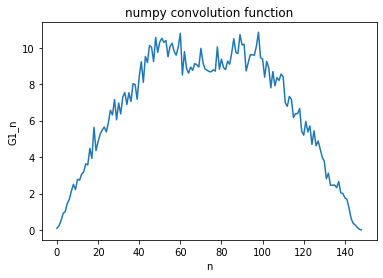

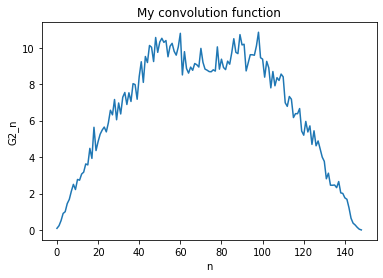

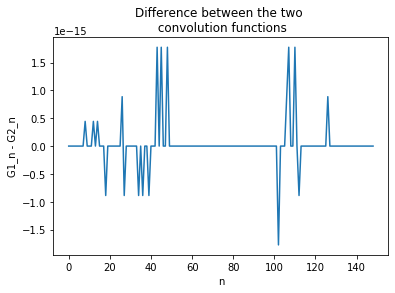

In [9]:
F = np.random.rand(50)
W = np.random.rand(100)

print("Notice that the difference between numpy.convolve and myConv is very small: ")
print(np.linalg.norm(np.convolve(F, W) - myConv(F, W)))


plt.plot(np.convolve(F, W))
plt.title("numpy convolution function")
plt.xlabel("n")
plt.ylabel("G1_n")
plt.show()
plt.plot(myConv(F, W))
plt.title("My convolution function")
plt.xlabel("n")
plt.ylabel("G2_n")
plt.show()
plt.plot(np.convolve(F, W) - myConv(F, W))
plt.title("Difference between the two \n convolution functions")
plt.xlabel("n")
plt.ylabel("G1_n - G2_n")
plt.show()

# 4.

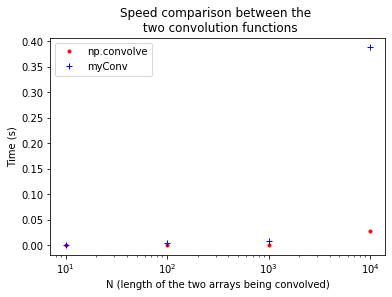

In [10]:
import time

numpyConvTimes=[]
myConvTimes=[]
N = [10, 100, 1000, 10000]

for n in N:
    F = np.random.rand(n)
    W = np.random.rand(n)
    
    t1 = time.time()
    g = np.convolve(F, W, 'same')
    t2 = time.time()
    
    numpyConvTimes.append(t2-t1)
    
    t1 = time.time()
    g = myConv(F, W)
    t2 = time.time()
    
    myConvTimes.append(t2-t1)
    
plt.plot(N, numpyConvTimes, 'r.', label="np.convolve")
plt.plot(N, myConvTimes, 'b+', label="myConv")
plt.xscale('log')
plt.title("Speed comparison between the \n two convolution functions")
plt.xlabel("N (length of the two arrays being convolved)")
plt.ylabel("Time (s)")
plt.legend(loc="upper left")
plt.show()


My function is slower than the numpy function. One possible reason is that the numpy function might be completely vectorized and has no for loop(s).

# Simple Physical System: RL Circuit Response (8 pts)

Consider a simple physical system consisting of a resistor (with resistance `R`) and an inductor (with
inductance `L`) in series. We apply an input voltage $a(t)$ across the pair in series, and measure the output
voltage $b(t)$ across the inductor alone. For this linear system,

 1. Show analytically that its step response (i.e., the $b(t)$ we obtain when the input voltage $a(t) = H(t)$,
    the Heaviside function) is given by

    $$ S(t) = e^{-Rt/L} H(t), $$

    and its impulse response (i.e., the output voltage $b(t)$ when $a(t) = \delta(t)$) is given by

    $$ R(t) = \delta(t) - \frac{R}{L} e^{-Rt/L} H(t). $$

    _Hint_: Construct and solve the ODE relating the voltages under consideration. Consider the two $b(t)$ choices to derive $S(t)$ and $R(t)$. Formulas $\frac{d}{dt} H(t) = \delta(t)$ and $\delta(t) f(t) = \delta(t) f(0)$ may help.
 2. Discretize the impulse response $R(t)$ function, realizing that $H(t)$ should be discretized as

    $$H = [0.5, 1, 1, \dots],$$

    and $\delta(t)$ should be discretized as

    $$D = [1/dt, 0, 0, \dots].$$

    Take advantage of your `myConv` function, or the NumPy built-in function `convolve`, and write
    your own Python function `V_out = RLresponse(R,L,V_in,dt)` to take an input series $V_{in}$ sampled
    at $\Delta = dt$, and calculate the output series $V_{out}$ sampled by the same $dt$. Please paste your
    Python function here. (Hint: here $\Delta$ may not be 1, so remember to build the multiplication of
    $\Delta$ into your convolution function.)
 3. Using $R = 850 \Omega$, $L = 2 H$, and sampling period $dt = 0.20 \text{ ms}$, test your RL-response
    function with {$H_n$} series (discretized $H(t)$) as input, and plot the output time series (as circles) on
    top of the theoretical curve $S(t)$ given by part 1 (as a solid line). Repeat this for {$D_n$} (discretized
    $\delta(t)$) and $R(t)$. Make the time range of the plots 0 to at least 20 ms. Please list your Python
    code here.

# Note: See end of PDF for question 2.1

# 2.2 & 2.3:

In [11]:
#R is the weighting function of the system because it is the output we get from sending in a pulse as the input. 
#Therefore, we can now use R (discretized) as the weighting function and do a covolution with V_in to get V_out

def RLresponse(r, L, V_in, dt):
    
    n = len(V_in)
    t = np.arange(0, 0.02, 0.0002)  # 20 mileseconds
    
    # create step and delta functions of the same length as V_in
    H = np.ones(n)
    H[0] = 0.5
    D = np.zeros(n)
    D[0] = 1.0/dt
    

    # Weight function (discretized R)
    R = D - (r/L)*np.exp((-1*r*t)/L)*H
    
    # convolve V_in and the weight function
    return np.convolve(R, V_in, mode='same')*dt

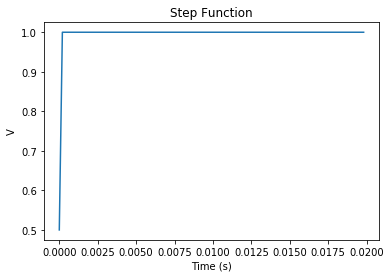

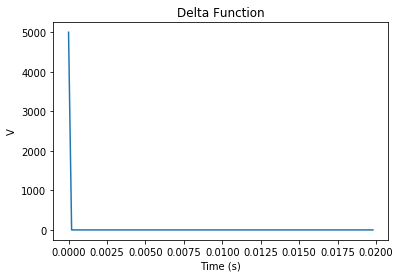

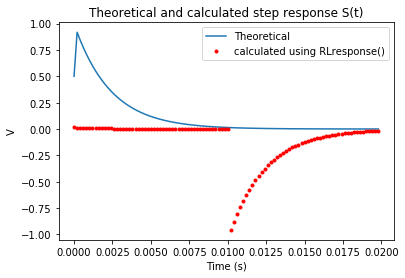

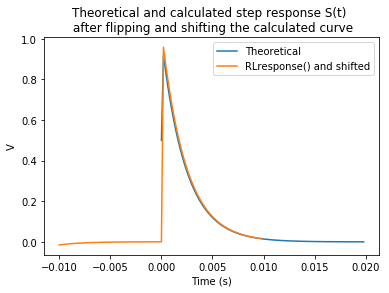

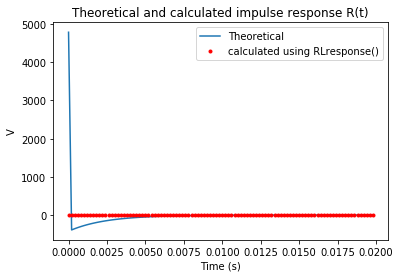

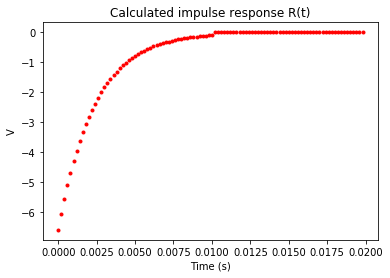

In [8]:
# Constants
r = 850.0
L = 2.0
dt = 0.0002 # 0.2 ms = 2 x 10^-4 s
n = 100  # want 0-20 ms, spaced 0.2 ms apart, so need 100 points

# input function is step function
v_in1 = np.ones(n)
v_in1[0] = 0.5

# second input function is delta function
v_in2 = np.zeros(n)
v_in2[0] = 1.0/dt

# time
t = np.arange(0, 0.02, dt)

plt.plot(t, v_in1)
plt.title("Step Function")
plt.ylabel("V")
plt.xlabel("Time (s)")
plt.show()

plt.plot(t, v_in2)
plt.title("Delta Function")
plt.ylabel("V")
plt.xlabel("Time (s)")

plt.show()

# Theoretical step response
H = v_in1[:]
D = v_in2[:]
S = np.exp(-1.0*r*t/L)*H

# Step response with my function
V_out1 = RLresponse(r, L, v_in1, dt)

# plotting
plt.plot(t, S, label='Theoretical')
plt.plot(t, V_out1, 'r.', label='calculated using RLresponse()')
plt.title("Theoretical and calculated step response S(t)")
plt.xlabel("Time (s)")
plt.ylabel("V")
plt.legend(loc="upper right")
plt.show()

plt.plot(t, S, label='Theoretical')
plt.plot(t-0.01, -V_out1, label='RLresponse() and shifted')
plt.xlabel("Time (s)")
plt.ylabel("V")
plt.title("Theoretical and calculated step response S(t) \n after flipping and shifting the calculated curve")
plt.legend(loc="upper right")

plt.show()



# Theoretical impulse response
R = D - (r/L)*np.exp((-1*r*t)/L)*H

# Impulse response with my function
V_out2 = RLresponse(r, L, v_in2, dt)

# plotting
plt.plot(t, R, label='Theoretical')
plt.plot(t, V_out2, 'r.', label='calculated using RLresponse()')
plt.title("Theoretical and calculated impulse response R(t)")
plt.xlabel("Time (s)")
plt.ylabel("V")
plt.legend(loc="upper right")
plt.show()

plt.plot(t, V_out2, 'r.')
plt.title("Calculated impulse response R(t)")
plt.xlabel("Time (s)")
plt.ylabel("V")
plt.show()

# Note


Obviously I didn't get this part correct. If you could provide any input as to where I went wrong I would really appreciate it. 


For step response:

It seems strange to me that the output of my function overlaps so well with the theoretical curve after I flipped and shifted it. I used mode='same' for np.convolve so that the output of RLresponse would be the same length as the theoretical curve (as in question 3), but this removes a large part of the graph (below I included what it looks like if I use mode='full').




For impulse response:

When I used 'full' convolution, the impulse response was the same as the theoretical one (see graph below)

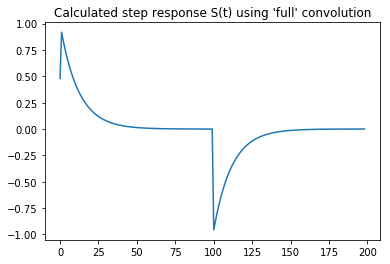

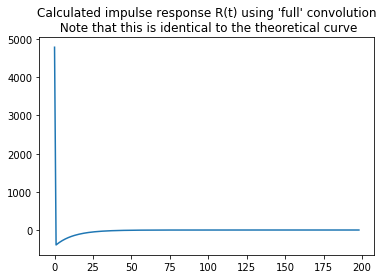

In [9]:
#R is the weighting function of the system because it is the output we get from sending in a pulse as the input. 
#Therefore, we can now use R (discretized) as the weighting function and do a covolution with V_in to get V_out

def RLresponse2(r, L, V_in, dt):
    
    n = len(V_in)
    t = np.arange(0, 0.02, 0.0002)  # 20 mileseconds
    
    # create step and delta functions of the same length as V_in
    H = np.ones(n)
    H[0] = 0.5
    D = np.zeros(n)
    D[0] = 1.0/dt

    
    # Weight function (discretized R)
    R = D - (r/L)*np.exp((-1*r*t)/L)*H
    
    # convolve V_in and the weight function
    return np.convolve(R, V_in, mode='full')*dt



# Step response with my function
V_out1 = RLresponse2(r, L, v_in1, dt)

# plotting
plt.plot(V_out1)
plt.title("Calculated step response S(t) using 'full' convolution")
plt.show()

# Impulse response with my function
V_out2 = RLresponse2(r, L, v_in2, dt)

# plotting
plt.plot(V_out2)
plt.title("Calculated impulse response R(t) using 'full' convolution"
          "\n Note that this is identical to the theoretical curve")
plt.show()

# Convolution of Synthetic Seismograms (5 pts)

Numerical simulations of seismic wave propagation can now be routinely done for [global and regional
earthquakes](http://global.shakemovie.princeton.edu/). For a recent southern Pakistan earthquake (Jan 18,
2011, 20:23:33 UTC), raw vertical synthetic seismogram (i.e., displacement field simulated at a seismic
station) for station `RAYN` (Ar Rayn, Saudi Arabia) is provided (`RAYN.II.LHZ.sem`). A common practice in
seismology is to convolve synthetic seismograms with a Gaussian function

$$ g(t) = \frac{1}{\sqrt{\pi}t_H} e^{-(t/t_H)^2} $$

to reflect either the time duration of the event or the accuracy of the numerical simulation.

 1. Provide two plots. Plot 1: the raw synthetic seismogram for station `RAYN` between 0 and 800 seconds. Plot 2: Gaussian
    functions with half duration $t_H = 10 \text{ sec}$ and $t_H = 20 \text{ sec}$ (include a legend). For the gaussians, use the same timestep $dt$ as the seismogram data.
 2. Use numpy's convolve function to convolve the raw timeseries with a Gaussian function (both $t_H = 10$ and $t_H = 20$ cases). Plot the raw data and the two convolved time series between 0 and 800 seconds on the same graph (include a legend) and comment on your results.

__Hints__

* The raw synthetics `RAYN.II.LHZ.sem` is given as a text file with two columns: time in seconds and
displacement in meters.
* Gaussian functions quickly decay to zero beyond $[-3t_H, 3t_H ]$, therefore it is sufficient to sample $g(t)$
within this interval.
* Use `mode='same'` when calling numpy convolve to truncate the convolution to the max of the supplied arrays (i.e. length of the raw timeseries in our case). This is convenient, since we want to compare the convolution output to the original timeseries. Alternatively, use the default mode (`'full'`) and truncate the output manually. 
* As a check for part 2, ensure that your convolved timeseries is aligned with (or "overlaps") the raw data timeseries.

In [10]:
data = np.loadtxt("RAYN.II.LHZ.sem").T
data.shape

(2L, 37200L)

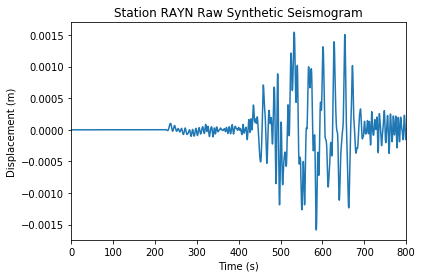

In [11]:
plt.plot(data[0], data[1])
plt.xlim([0,800])
plt.title("Station RAYN Raw Synthetic Seismogram")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.show()

In [12]:
def Gaussian(tH, delta):
    
 
    t = np.arange(-3*tH, 3*tH, delta)
    
    return t, (np.exp(-1.0*((t/tH)**2)))/(tH*np.sqrt(np.pi))
    
    

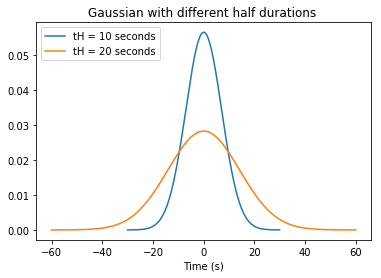

In [13]:
# get delta from seismogram data
delta = data[0,1]-data[0,0]

# plot gaussians for tH=10 and tH=20
t1, g1 = Gaussian(10, delta)
t2, g2 = Gaussian(20, delta)

plt.plot(t1, g1, label="tH = 10 seconds")
plt.plot(t2, g2, label="tH = 20 seconds")
plt.title("Gaussian with different half durations ")
plt.xlabel("Time (s)")
plt.legend(loc="upper left")

plt.show()

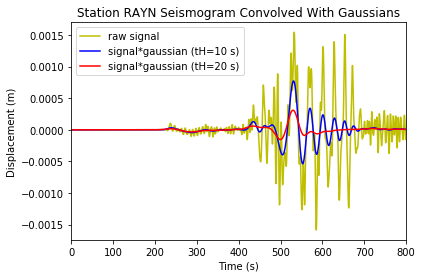

In [15]:
convolution1 = np.convolve(data[1], g1, 'same')*delta
convolution2 = np.convolve(data[1], g2, 'same')*delta
plt.plot(data[0], data[1], 'y',label='raw signal')
plt.plot(data[0], convolution1, 'b',label='signal*gaussian (tH=10 s)')
plt.plot(data[0], convolution2, 'r', label='signal*gaussian (tH=20 s)')
plt.xlim([0,800])
plt.legend(loc="upper left")
plt.title("Station RAYN Seismogram Convolved With Gaussians")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.show()

The narrower gaussian captures more of the fine details, where as the wider one seems to smooth out the curve more. I guess convolution with the wider gaussian might be useful for seeing effects that act on a longer time scale, whereas the narrower one is better suited for picking up on short time scale variations.

Note that the numpy convolution function assumes delta=1, so I have multiplied by delta.